# Python Basics


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvFileAddress = input('Enter CSV File Address:')

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.insert(7, '<ISGREEN>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ.insert(9, '<VOLATILITY>',value=0)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<HIGH>','<LOW>','<TICKVOL>','<VOL>','<SPREAD>'],axis=1,inplace=True)



In [55]:
DJ

,<DATE>,<TIME>,<OPEN>,<CLOSE>,<ISGREEN>,<SIZE>,<VOLATILITY>
0,2021.11.08,01:00:00,36348,36319,False,-29,44
1,2021.11.08,02:00:00,36319,36306,False,-13,40
2,2021.11.08,03:00:00,36306,36294,False,-12,60
3,2021.11.08,04:00:00,36294,36313,True,19,32
4,2021.11.08,05:00:00,36313,36304,False,-9,19
...,...,...,...,...,...,...,...
2710,2022.05.02,18:00:00,33014,32948,False,-66,229
2711,2022.05.02,19:00:00,32945,32764,False,-181,256
2712,2022.05.02,20:00:00,32768,32664,False,-104,233
2713,2022.05.02,21:00:00,32663,32566,False,-97,279


In [58]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) )*60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [27]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>','<OPEN>','<CLOSE>','<ISGREEN>','<SIZE>','<VOLATILITY>'])




for i in range(uniqueDaysCount):

    if(i%120==0):
        print((int(i/uniqueDaysCount*10000))/100 , '%')
    for j in range(CandlesInDay):
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j),0,0,0,0,0]


0.0 %
55.81 %


In [32]:
newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x','<CLOSE>_y','<OPEN>_y'],inplace=True)
newestDF['<ISGREEN>_y'] = newestDF['<ISGREEN>_y'].fillna(0)
newestDF['<SIZE>_y'] = newestDF['<SIZE>_y'].fillna(0)
newestDF['<VOLATILITY>_y'] = newestDF['<VOLATILITY>_y'].fillna(0)

newestDF

,<DATE>,<TIME>,<ISGREEN>_y,<SIZE>_y,<VOLATILITY>_y
0,2021.10.01,00:00:00,True,18.4,125.9
1,2021.10.01,00:20:00,True,159.4,212.4
2,2021.10.01,00:40:00,True,146.9,236.6
3,2021.10.01,01:00:00,False,-20.8,146.9
4,2021.10.01,01:20:00,False,-16.6,221.6
...,...,...,...,...,...
15475,2022.05.03,22:20:00,0,0.0,0.0
15476,2022.05.03,22:40:00,0,0.0,0.0
15477,2022.05.03,23:00:00,0,0.0,0.0
15478,2022.05.03,23:20:00,0,0.0,0.0


In [33]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i][0]
    time = newestDF.iloc[i][1]
    isGreen = newestDF.iloc[i][2]
    size = newestDF.iloc[i][3]
    volatility = newestDF.iloc[i][4]
    
    list.append([date, time, isGreen, size, volatility])


In [34]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [35]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][4])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][3])> avgCandleBodySize*avgMultiplier and abs(day[j][3])> 0:
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    countVector.append(eachDayMatrix(days[i])[1])
    ansVector.append(eachDayMatrix(days[i])[0])

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

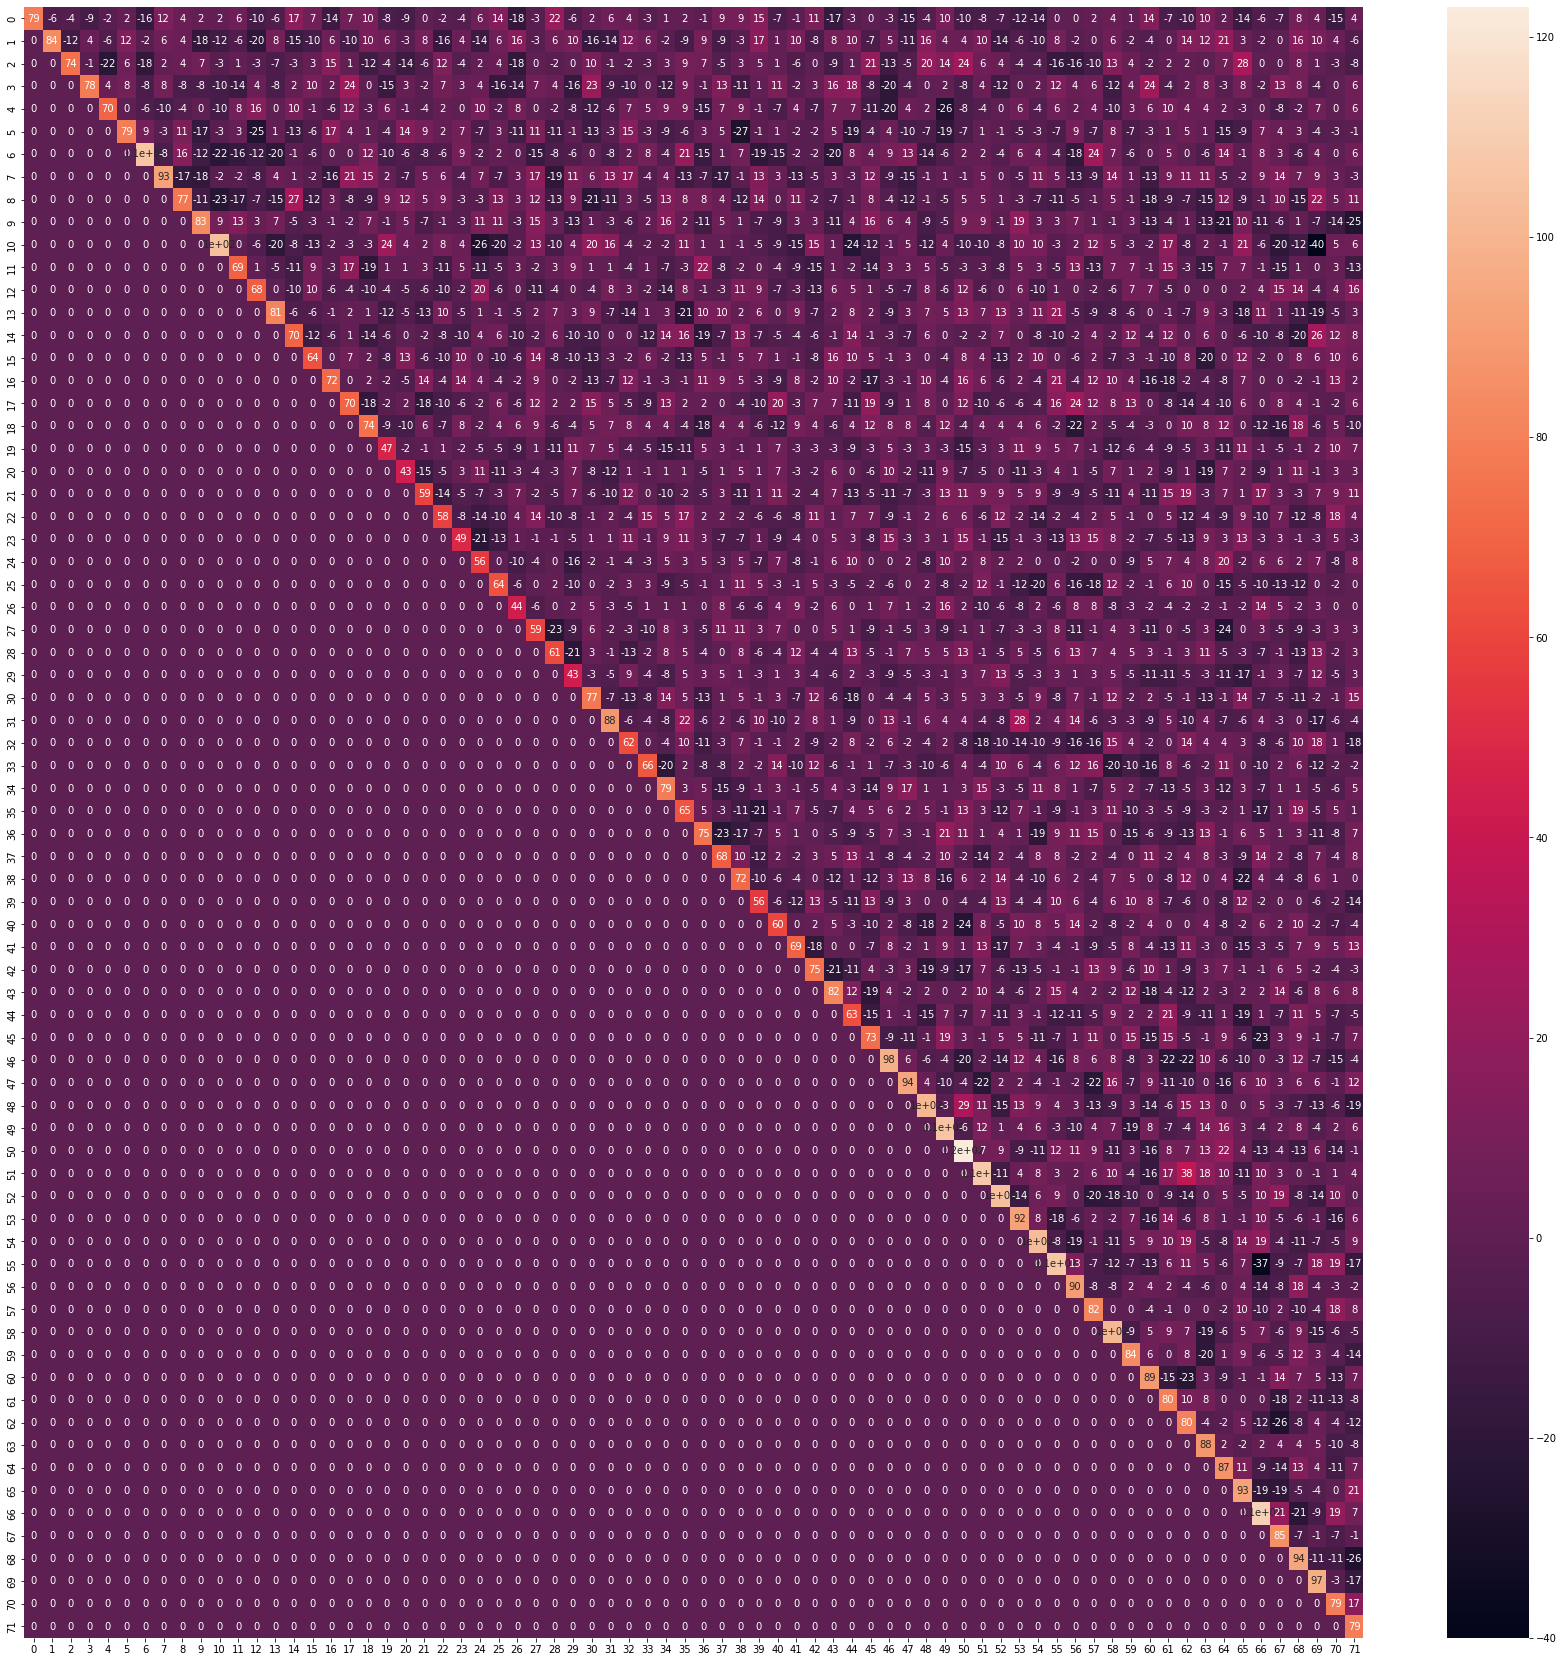

In [36]:
plt.figure(figsize=(30,30))
sns.heatmap(final,annot=True,)


<AxesSubplot:>

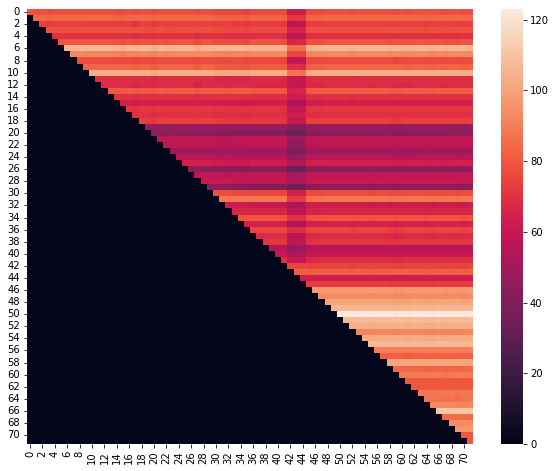

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(countFinal,annot=False,)


In [41]:
# float(input('Bias:')) 
biasPercentage = 65

consecutiveAndClose = True
consecutiveOnly = False
percentTimesCountedAtLeastMoreThan = 50

print('Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg,'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg,'Consecutive')
                continue
            if(j-i <= 120/timeFrame) and (not consecutiveOnly):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg,'Close') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg,'Close')
                continue
            if not(consecutiveAndClose or consecutiveOnly): 
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg)




Averages Multiplier : 1.0
66-67 22:00:00-22:20:00 68.91% ++ 51.62 Consecutive
66-68 22:00:00-22:40:00 68.91% -- 51.62 Close
66-70 22:00:00-23:20:00 67.11% ++ 51.62 Close
